In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn import metrics as mt
from sklearn.metrics import roc_curve, auc
import operator
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KDTree

### Functions for ROC stuff

In [2]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#probs is the result of a model.predict_proba(x_test) call

#This function plots an ROC curve
def rocCurvePlot(probs, y_test1):
    # calculate the fpr and tpr for all thresholds of the classification
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test1, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
# A function to find the optimal cutoff point from ROC curve

#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted):
    """Parameters:
    target : Matrix with dependent or target data, where rows are observations
    predicted : Matrix with predicted data, where rows are observations
    ----------
    Return: list type, with optimal cutoff value
    """
    predicted = predicted[:,1]
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

### Import the data

In [3]:
directory = 'C:/githubrepo/7331_Project/data/'
df_zg = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
print("Done reading data.")

Done reading data.


### Makes lists of the different types

In [4]:
ordinal = ["age", "time_in_hospital"]
categorical = ["race", "gender", "admission_type_id", "discharge_disposition_id",
               "admission_source_id", "medical_specialty", "max_glu_serum",
               "A1Cresult", "change", "diabetesMed", "diag_1_val", "diag_2_val",
               "diag_3_val", "meds_increased"]
continuous = ["num_lab_procedures", "num_procedures", "num_medications",
              "number_outpatient", "number_emergency", "number_inpatient",
              "number_diagnoses", "medication_count"]
lcontinuous = ["lnum_lab_procedures", "lnum_procedures", "lnum_medications",
              "lnumber_outpatient", "lnumber_emergency", "lnumber_inpatient",
              "lnumber_diagnoses", "lmedication_count"]
medicines = ["metformin", "repaglinide", "nateglinide", "chlorpropamide",
             "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
             "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
             "tolazamide", "insulin", "glyburide-metformin", "glipizide-metformin",
             "metformin-rosiglitazone", "metformin-pioglitazone"]
response = ["readmitted_tf"]

### Dataframes of each type of data

In [5]:
df_zg_ordinal = df_zg[ordinal]
df_zg_categorical = df_zg[categorical]
df_zg_continuous = df_zg[continuous]
df_zg_lcontinuous = np.log(df_zg_continuous)
df_zg_lcontinuous.columns = lcontinuous
df_zg_medicines = df_zg[medicines]
df_zg_response = df_zg[response]

### Make Age ordinal

In [6]:
for i in range(0, 10):
    val = "[" + str(i*10) + "-" + str((i+1)*10) + ")"
    df_zg_ordinal.loc[df_zg_ordinal['age'] == val, 'age'] = i

### Making all categorical columns categorical

In [7]:
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['discharge_disposition_id'] = df_zg_categorical['discharge_disposition_id'].astype(object)
df_zg_categorical['admission_source_id'] = df_zg_categorical['admission_source_id'].astype(object)
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['meds_increased'] = df_zg_categorical['meds_increased'].astype(object)
#df_zg_response['readmitted_tf'] = df_zg_response['readmitted_tf'].astype(object)
print("Done")

Done


In [8]:
df_zg_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous], axis = 1)
df_zg_num_x = pd.concat([df_zg_ordinal, df_zg_continuous], axis = 1)
df_zg_med_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous, df_zg_medicines], axis = 1)
df_zg_hot_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous], axis = 1)
df_zg_hot_med_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous, pd.get_dummies(df_zg_medicines)], axis = 1)
df_zg_y = df_zg_response
print("Done")

Done


### Function for setting up the training, validation, and test sets

In [15]:
def tvt_split(df_x, df_y, valid_size, t_size, seed):
    #doing the math because we have to split 2 seperate times
    valid_size = 100*valid_size/(100*(1-t_size))
    #First splitting out the test set
    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = t_size, random_state=seed)
    #Splitting the training set into train/validate
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = valid_size, random_state=seed)

    #Reseting allof the indices
    x_train.reset_index()
    y_train.reset_index()
    x_test.reset_index()
    y_test.reset_index()
    x_valid.reset_index()
    y_valid.reset_index()

    return x_train, x_valid, x_test, y_train, y_valid, y_test

# KNN

### Do the split

In [16]:
%%time
x_train, x_valid, x_test, y_train, y_valid, y_test = tvt_split(df_zg_hot_x, df_zg_y, 0.2, 0.2, 7)

#Print out the shapes of the train/valid/test sets
x_train.shape, x_valid.shape, x_test.shape

#Create variables for just this operation
x_t = x_train
x_v = x_valid
y_t = y_train
y_v = y_valid
y_tst = y_test

# We will fill this with predictions
yhat = np.zeros(y_v.shape)

scl = StandardScaler()
x_t = scl.fit_transform(x_train)
x_v = scl.transform(x_valid)
x_tst = scl.transform(x_test)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Wall time: 743 ms


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


# KNN Tuning on reduced set

### Testing k=1 first to see how long it takes

In [18]:
%%time
# creating odd list of K for KNN
myList = list(range(1,2))
# subsetting just the odd ones
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
scores = pd.DataFrame(columns = ["K", "AUC_Train", "AUC_Valid"])

i = 0
for k in neighbors:
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(x_t, y_t)

    #AUC
    auc_t = roc_auc_score(y_t, clf.predict_proba(x_t)[:,1])
    auc_v = roc_auc_score(y_v, clf.predict_proba(x_v)[:,1])
    scores.loc[i] = [k, auc_t, auc_v]
    i = i+1
print(scores)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':


     K  AUC_Train  AUC_Valid
0  1.0        1.0   0.591931
Wall time: 14min 13s


### Testing 2-17 (odd values)
Creates the model for each of the K's in that range and then saves the AUC for the train and validation sets.

In [19]:
%%time
# creating odd list of K for KNN
myList = list(range(2,18))
# subsetting just the odd ones
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
scores1 = pd.DataFrame(columns = ["K", "AUC_Train", "AUC_Valid"])

i = 0
for k in neighbors:
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(x_t, y_t)

    #AUC
    auc_t = roc_auc_score(y_t, clf.predict_proba(x_t)[:,1])
    auc_v = roc_auc_score(y_v, clf.predict_proba(x_v)[:,1])
    scores1.loc[i] = [k, auc_t, auc_v]
    i = i+1
    print(k)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':


3


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':


5


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':


7


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':


9


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':


11


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':


13


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':


15


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':


17
Wall time: 2h 8min 7s


### Plotting K's 1 - 17 (odd values)
Using the validation set in order to see how large of a k to use. From the plot below we can see the they are asymptotically approaching 0.73. Because this is a large dataset (100k+ rows) we can use a little larger k and will not run a large risk of overfitting. Based on the data below a K of 15 would be a good choice.

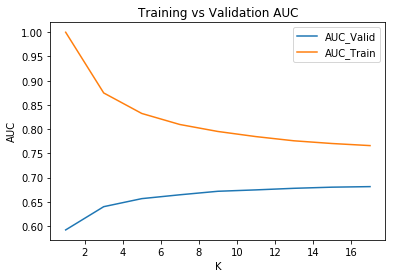

In [20]:
df_scores_0_70 = pd.concat([scores, scores1])
df_scores_0_70.columns = ["K", "AUC_Train", "AUC_Valid"]

plt.plot(df_scores_0_70.K, df_scores_0_70.AUC_Valid)
plt.plot(df_scores_0_70.K, df_scores_0_70.AUC_Train)

plt.xlabel('K') 
plt.ylabel('AUC') 
plt.legend()
plt.title('Training vs Validation AUC') 

plt.show()

### KNN with the above parameters
Now that we have tuned the values for K, we do the prediction on the test set. Below shows the ROC curve with all of the accuracy metrics and confusion matrix.

In [21]:
%%time
clf = KNeighborsClassifier(n_neighbors = 7)
clf.fit(x_t, y_t)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Wall time: 5.79 s


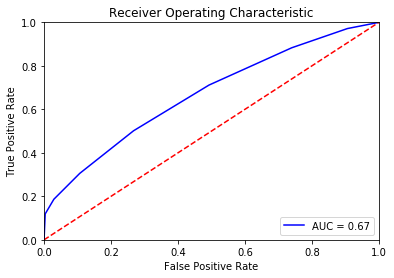

F1: 0.6207 ACC: 0.6261 AUC: 0.6686
Specificity: 0.5014 Sensitivity: 0.7327

Confusion Matrix
 [[8037 2932]
 [4679 4706]]
Wall time: 15min 30s


In [22]:
%%time
#Find the optimal cutoff point
y_pred_cut = clf.predict_proba(x_t)
cutoff = Find_Optimal_Cutoff(y_t, y_pred_cut)

#Prediction
y_pred_probs = clf.predict_proba(x_tst)
y_pred = np.where(y_pred_probs >= cutoff, 1, 0)
y_pred = y_pred[:,1]

rocCurvePlot(y_pred_probs, y_tst)

#Accuracy metrics
f1 = f1_score(y_tst, y_pred, average = 'weighted')
acc = accuracy_score(y_tst, y_pred)
auc = roc_auc_score(y_tst, y_pred_probs[:,1])
conf = mt.confusion_matrix(y_tst, y_pred)
sens = conf[0,0]/(conf[0,0] + conf[0,1])
spec = conf[1,1]/(conf[1,0] + conf[1,1])
print("F1:", round(f1,4), "ACC:", round(acc,4), "AUC:", round(auc,4))
print("Specificity:", round(spec, 4), "Sensitivity:", round(sens, 4))
print("\nConfusion Matrix\n", conf)